In [4]:
!pip install PyWavelets
from google.colab import drive
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Bidirectional, LSTM, Dense, Dropout, BatchNormalization
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
import pywt  # For Discrete Wavelet Transform (DWT)
from sklearn.feature_selection import RFE
from sklearn.svm import SVC
!pip install antropy
import antropy as ant  # For Approximate and Fuzzy Entropy
!pip install hurst
from hurst import compute_Hc  # For Hurst Exponent
from scipy.io import savemat


In [5]:
# Mount Google Drive
drive.mount('/content/drive')

# Define input and output folders
input_folder = "/content/drive/MyDrive/EEG Dataset"
processed_folder = os.path.join(input_folder, "Processed_CNN_BiLSTM")
model_save_folder = os.path.join(input_folder, "Models_CNN_BiLSTM")
os.makedirs(processed_folder, exist_ok=True)
os.makedirs(model_save_folder, exist_ok=True)

Mounted at /content/drive


In [40]:
# Define label mapping for 3-class classification
label_map = {"F": 0, "N": 0, "O": 1, "Z": 1, "S": 2}  # Three-class classification

# Function to apply band-pass filter
def bandpass_filter(signal, lowcut=0.5, highcut=50, fs=173.61, order=4):
    from scipy.signal import butter, filtfilt
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    return filtfilt(b, a, signal)

# Feature Extraction Function
def extract_features(signal):
    coeffs = pywt.wavedec(signal, wavelet='db4', level=4)
    dwt_features = [np.mean(c) for c in coeffs] + [np.std(c) for c in coeffs]
    apen = ant.app_entropy(signal)
    fuen = ant.perm_entropy(signal, order=2, normalize=True)
    rms = np.sqrt(np.mean(signal**2))
    hurst_exp, _, _ = compute_Hc(signal, kind='random_walk')
    return np.array(dwt_features + [apen, fuen, rms, hurst_exp])

In [46]:
# Load and preprocess data
all_features, all_labels = [], []
for folder in label_map.keys():
    folder_path = os.path.join(input_folder, folder)
    if not os.path.exists(folder_path):
        print(f"Warning: {folder_path} not found. Skipping...")
        continue

    for file in os.listdir(folder_path):
        if file.endswith(".txt") or file.endswith(".TXT"):
            file_path = os.path.join(folder_path, file)
            signal = np.loadtxt(file_path)
            filtered_signal = bandpass_filter(signal)
            scaler = StandardScaler()
            normalized_signal = scaler.fit_transform(filtered_signal.reshape(-1, 1)).flatten()
            features = extract_features(normalized_signal)
            all_features.append(features)
            all_labels.append(label_map[folder])

# Convert to numpy arrays
X = np.array(all_features)
y = np.array(all_labels)
y = LabelEncoder().fit_transform(y)
num_classes = len(np.unique(y))
y = tf.keras.utils.to_categorical(y, num_classes=num_classes)

In [47]:
from tensorflow.keras.layers import Input
from tensorflow.keras.optimizers import Adam
# Define CNN-BiLSTM model (following the exact architecture from the paper)
def create_cnn_bilstm_model(input_shape, num_classes):
    model = Sequential([
        Input(shape=(input_shape, 1)),
        Conv1D(filters=64, kernel_size=3, activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling1D(pool_size=2),
        Conv1D(filters=128, kernel_size=3, activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling1D(pool_size=2),
        Conv1D(filters=256, kernel_size=3, activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling1D(pool_size=2),
        Bidirectional(LSTM(64, return_sequences=True)),
        Bidirectional(LSTM(32, return_sequences=False)),
        Flatten(),
        Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.0001)),
        Dropout(0.3),
        Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer=Adam(learning_rate=0.001),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

# Train model
model = create_cnn_bilstm_model(input_shape=X.shape[1], num_classes=num_classes)
model.summary()



Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_30 (Conv1D)                   │ (None, 14, 64)              │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_30               │ (None, 14, 64)              │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_30 (MaxPooling1D)      │ (None, 7, 64)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_31 (Conv1D)                   │ (None, 7, 128)              │          24,704 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_31               │ (None, 7, 128)              │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_31 (MaxPooling1D)      │ (None, 3, 128)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_32 (Conv1D)                   │ (None, 3, 256)              │          98,560 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_32               │ (None, 3, 256)              │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_32 (MaxPooling1D)      │ (None, 1, 256)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_20 (Bidirectional)     │ (None, 1, 128)              │         164,352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_21 (Bidirectional)     │ (None, 64)                  │          41,216 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_10 (Flatten)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_20 (Dense)                     │ (None, 128)                 │           8,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_10 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_21 (Dense)                     │ (None, 3)                   │             387 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 339,587 (1.30 MB)

 Trainable params: 338,691 (1.29 MB)

 Non-trainable params: 896 (3.50 KB)

/usr/local/lib/python3.11/dist-packages/sklearn/feature_selection/_rfe.py:300: UserWarning: Found n_features_to_select=30 > n_features=14. There will be no feature selection and all features will be kept.
  warnings.warn(


Epoch 1/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 11s 189ms/step - accuracy: 0.5594 - loss: 1.0299 - val_accuracy: 0.5000 - val_loss: 1.0867
Epoch 2/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.7912 - loss: 0.6945 - val_accuracy: 0.7800 - val_loss: 1.0615
Epoch 3/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.8088 - loss: 0.5174 - val_accuracy: 0.4200 - val_loss: 1.0606
Epoch 4/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.8534 - loss: 0.3866 - val_accuracy: 0.4000 - val_loss: 1.0618
Epoch 5/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.9097 - loss: 0.2883 - val_accuracy: 0.4000 - val_loss: 1.0747
Epoch 6/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.9510 - loss: 0.1903 - val_accuracy: 0.4000 - val_loss: 1.0767
Epoch 7/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.9331 - loss: 0.2139 - val_accuracy: 0.4000 - val_loss: 1.0976
Epoch 8/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.9511 - loss: 0.1664 - val_accuracy: 0.4000 - val_los

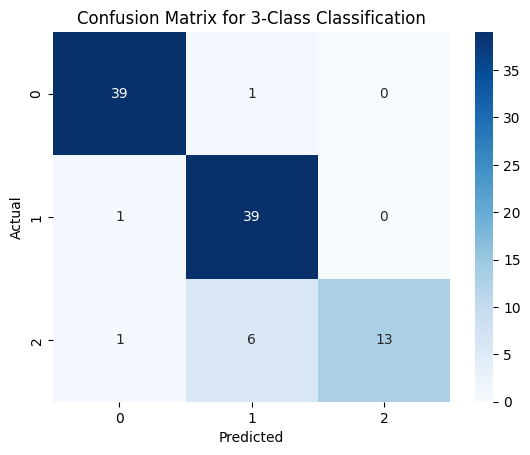

In [48]:
# Train-Test Split Before Feature Selection
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Apply Feature Selection After Splitting
svm = SVC(kernel='linear')
rfe = RFE(svm, n_features_to_select=30)  # Keep more features to avoid losing useful information
X_train_selected = rfe.fit_transform(X_train, np.argmax(y_train, axis=1))
X_test_selected = rfe.transform(X_test)  # Apply the same transformation

# Reshape for CNN-BiLSTM
X_train_selected = X_train_selected.reshape(X_train_selected.shape[0], X_train_selected.shape[1], 1)
X_test_selected = X_test_selected.reshape(X_test_selected.shape[0], X_test_selected.shape[1], 1)

# Learning Rate Scheduler
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.001,
    decay_steps=100,
    decay_rate=0.9
)
optimizer = Adam(learning_rate=lr_schedule)

# Train BiLSTM Model
model = create_cnn_bilstm_model(input_shape=X_train_selected.shape[1], num_classes=num_classes)
history = model.fit(X_train_selected, y_train, epochs=100, batch_size=64, validation_data=(X_test_selected, y_test), verbose=1)

# Evaluate the Model
y_pred = model.predict(X_test_selected)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

# Print Classification Report
print("\nClassification Report:")
print(classification_report(y_true_classes, y_pred_classes))

# Plot Confusion Matrix
cm = confusion_matrix(y_true_classes, y_pred_classes)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for 3-Class Classification')
plt.show()


In [49]:
# Save model
model.save(os.path.join(model_save_folder, "cnn_bilstm_3class.h5"))

Mounted at /content/drive
Epoch 1/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 18s 566ms/step - accuracy: 0.5492 - loss: 6.1229 - val_accuracy: 0.2100 - val_loss: 8.5739
Epoch 2/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 7s 499ms/step - accuracy: 0.8844 - loss: 2.4661 - val_accuracy: 0.2000 - val_loss: 35.1418
Epoch 3/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 6s 459ms/step - accuracy: 0.9563 - loss: 0.5663 - val_accuracy: 0.2000 - val_loss: 57.9312
Epoch 4/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 6s 504ms/step - accuracy: 0.9674 - loss: 0.3665 - val_accuracy: 0.2000 - val_loss: 85.2252
Epoch 5/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 6s 457ms/step - accuracy: 0.9811 - loss: 0.1290 - val_accuracy: 0.2000 - val_loss: 109.4994
Epoch 6/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 7s 508ms/step - accuracy: 0.9833 - loss: 0.1555 - val_accuracy: 0.2000 - val_loss: 129.0526
Epoch 7/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 11s 523ms/step - accuracy: 0.9869 - loss: 0.1457 - val_accuracy: 0.2000 - val_loss: 152.6413
Epoch 8/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 7s 509ms/step - accur

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 296ms/step

Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.97      0.94        40
           1       0.97      0.93      0.95        40
           2       0.95      0.90      0.92        20

    accuracy                           0.94       100
   macro avg       0.94      0.93      0.94       100
weighted avg       0.94      0.94      0.94       100



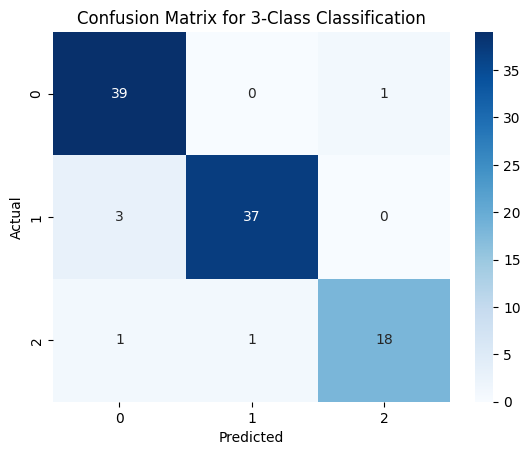

In [1]:
# Google Colab Notebook for Implementing BiLSTM-CNN on Bonn Dataset

# Mount Google Drive
from google.colab import drive
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Bidirectional, LSTM, Dense, Dropout, BatchNormalization, Input
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.signal import butter, filtfilt

# Mount Google Drive
drive.mount('/content/drive')

# Define input and output folders
input_folder = "/content/drive/MyDrive/EEG Dataset"
processed_folder = os.path.join(input_folder, "Processed_BiLSTM_CNN")
model_save_folder = os.path.join(input_folder, "Models_BiLSTM_CNN")
os.makedirs(processed_folder, exist_ok=True)
os.makedirs(model_save_folder, exist_ok=True)

# Define label mapping for 3-class classification
label_map = {"F": 0, "N": 0, "O": 1, "Z": 1, "S": 2}  # Three-class classification

# Function to apply band-pass filter
def bandpass_filter(signal, lowcut=0.5, highcut=50, fs=173.61, order=4):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    return filtfilt(b, a, signal)

# Load and preprocess data
all_features, all_labels = [], []
for folder in label_map.keys():
    folder_path = os.path.join(input_folder, folder)
    if not os.path.exists(folder_path):
        print(f"Warning: {folder_path} not found. Skipping...")
        continue

    for file in os.listdir(folder_path):
        if file.endswith(".txt") or file.endswith(".TXT"):
            file_path = os.path.join(folder_path, file)
            signal = np.loadtxt(file_path)
            filtered_signal = bandpass_filter(signal)
            scaler = StandardScaler()
            normalized_signal = scaler.fit_transform(filtered_signal.reshape(-1, 1)).flatten()
            all_features.append(normalized_signal)
            all_labels.append(label_map[folder])

# Convert to numpy arrays
X = np.array(all_features)
y = np.array(all_labels)
y = LabelEncoder().fit_transform(y)
num_classes = len(np.unique(y))
y = tf.keras.utils.to_categorical(y, num_classes=num_classes)

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Reshape for BiLSTM-CNN
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

# Define BiLSTM-CNN Model
def create_bilstm_cnn_model(input_shape, num_classes):
    model = Sequential([
        Input(shape=(input_shape, 1)),

        # BiLSTM Layers
        Bidirectional(LSTM(64, return_sequences=True)),
        Bidirectional(LSTM(32, return_sequences=True)),

        # CNN Layers
        Conv1D(filters=64, kernel_size=3, activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling1D(pool_size=2),
        Conv1D(filters=128, kernel_size=3, activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling1D(pool_size=2),

        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.4),
        Dense(num_classes, activation='softmax')
    ])

    model.compile(optimizer=Adam(learning_rate=0.001),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

# Train BiLSTM-CNN model
model = create_bilstm_cnn_model(input_shape=X_train.shape[1], num_classes=num_classes)
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test), verbose=1)

# Save model
model.save(os.path.join(model_save_folder, "bilstm_cnn.h5"))

# Evaluate the Model
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

# Print Classification Report
print("\nClassification Report:")
print(classification_report(y_true_classes, y_pred_classes))

# Plot Confusion Matrix
cm = confusion_matrix(y_true_classes, y_pred_classes)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for 3-Class Classification')
plt.show()


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Epoch 1/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 12s 566ms/step - accuracy: 0.5947 - loss: 4.7722 - val_accuracy: 0.5100 - val_loss: 1.7399
Epoch 2/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 7s 504ms/step - accuracy: 0.8351 - loss: 2.3207 - val_accuracy: 0.3800 - val_loss: 4.3533
Epoch 3/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 10s 494ms/step - accuracy: 0.9621 - loss: 0.7531 - val_accuracy: 0.4000 - val_loss: 5.7176
Epoch 4/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 6s 458ms/step - accuracy: 0.9731 - loss: 0.6571 - val_accuracy: 0.2600 - val_loss: 11.9838
Epoch 5/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 10s 458ms/step - accuracy: 0.9752 - loss: 0.2094 - val_accuracy: 0.2100 - val_loss: 17.8888
Epoch 6/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 10s 459ms/step - accuracy: 0.9812 - loss: 0.0989 - val_accuracy: 0.2000 - val_loss: 27.9540
Epoch 7/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 11s 533ms/step - accuracy: 0.9775 - loss: 0.1514 - 

4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 394ms/step

Classification Report:
              precision    recall  f1-score   support

           0       0.87      1.00      0.93        40
           1       0.97      0.90      0.94        40
           2       0.94      0.80      0.86        20

    accuracy                           0.92       100
   macro avg       0.93      0.90      0.91       100
weighted avg       0.93      0.92      0.92       100



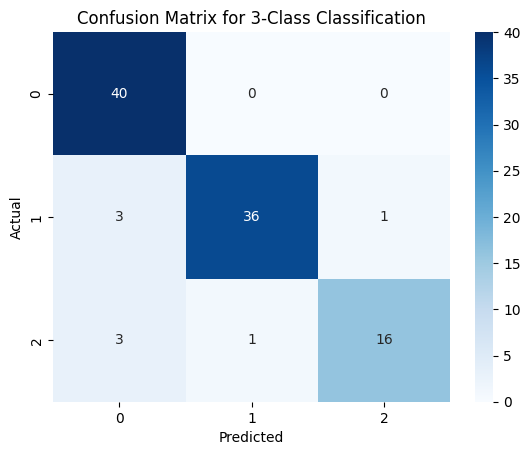

In [9]:
# Google Colab Notebook for Implementing BiLSTM-CNN on Bonn Dataset

# Mount Google Drive
from google.colab import drive
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Bidirectional, LSTM, Dense, Dropout, BatchNormalization, Input
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.signal import butter, filtfilt
from scipy.io import loadmat, savemat
import glob

# Mount Google Drive
drive.mount('/content/drive')

# Define input and output folders
input_folder = "/content/drive/MyDrive/EEG Dataset"
processed_folder = os.path.join(input_folder, "Processed_BiLSTM_CNN")
model_save_folder = os.path.join(input_folder, "Models_BiLSTM_CNN")
os.makedirs(processed_folder, exist_ok=True)
os.makedirs(model_save_folder, exist_ok=True)

# Define label mapping for 3-class classification
label_map = {"F": 0, "N": 0, "O": 1, "Z": 1, "S": 2}  # Three-class classification

def bandpass_filter(signal, lowcut=0.5, highcut=50, fs=173.61, order=4):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    return filtfilt(b, a, signal)

# Load and preprocess EEG data
def preprocess_eeg(folder_path):
    file_paths = sorted(glob.glob(os.path.join(folder_path, "*.txt")) + glob.glob(os.path.join(folder_path, "*.TXT")))
    processed_data = []

    for file_path in file_paths:
        data = np.loadtxt(file_path)  # Load EEG signal
        data = bandpass_filter(data, 0.5, 50, 173.61, 5)  # Apply filtering
        data = (data - np.mean(data)) / np.std(data)  # Normalize to zero mean, unit variance
        processed_data.append(data)

    return np.array(processed_data)

# Process and load all data
data_folders = ['F', 'N', 'O', 'S', 'Z']
all_features, all_labels = [], []

for folder in data_folders:
    folder_path = os.path.join(input_folder, folder)
    if not os.path.exists(folder_path):
        print(f"Warning: {folder_path} not found. Skipping...")
        continue

    processed_eeg = preprocess_eeg(folder_path)
    save_path = os.path.join(processed_folder, f"processed_bi_{folder}.mat")
    savemat(save_path, {"eeg_data": processed_eeg})

    all_features.append(processed_eeg)
    all_labels.append(np.full((processed_eeg.shape[0],), label_map[folder]))

# Convert to numpy arrays
X = np.vstack(all_features)
y = np.concatenate(all_labels)

# Normalize dataset
scaler = StandardScaler()
X = scaler.fit_transform(X)
X = X.reshape((X.shape[0], X.shape[1], 1))  # Reshape for LSTM

# One-hot encode labels
y = tf.keras.utils.to_categorical(y, num_classes=len(np.unique(y)))

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Define BiLSTM-CNN Model
def create_bilstm_cnn_model(input_shape, num_classes):
    model = Sequential([
        Input(shape=(input_shape, 1)),

        # BiLSTM Layers
        Bidirectional(LSTM(64, return_sequences=True)),
        Bidirectional(LSTM(32, return_sequences=True)),

        # CNN Layers
        Conv1D(filters=64, kernel_size=3, activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling1D(pool_size=2),
        Conv1D(filters=128, kernel_size=3, activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling1D(pool_size=2),

        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.4),
        Dense(num_classes, activation='softmax')
    ])

    model.compile(optimizer=Adam(learning_rate=0.001),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

# Train BiLSTM-CNN model
model = create_bilstm_cnn_model(input_shape=X_train.shape[1], num_classes=y.shape[1])
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test), verbose=1)

# Save model
model.save(os.path.join(model_save_folder, "bilstm_2.h5"))

# Evaluate the Model
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

# Print Classification Report
print("\nClassification Report:")
print(classification_report(y_true_classes, y_pred_classes))

# Plot Confusion Matrix
cm = confusion_matrix(y_true_classes, y_pred_classes)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for 3-Class Classification')
plt.show()
